In [132]:
import arviz
import numpy as np
import pandas as pd
import pystan

In [133]:
# Parameters
P = 10
N = 10 ** 4

In [134]:
# Ground truth
true_transmission_rate = np.random.beta(2, 10, P)
true_occurrence_rate = np.random.beta(2, 10, P)
base_rate = np.random.beta(2, 10, 1)

In [135]:
# Simulate data
data = {}
for p in range(P):
    occurrence = np.random.binomial(1, true_occurrence_rate[p], N)
    transmission = occurrence * np.random.binomial(1, true_transmission_rate[p], N)
    data[f'O{p+1}'] = occurrence
    data[f'T{p+1}'] = transmission
data['T0'] = np.random.binomial(1, base_rate, N)
X = pd.DataFrame(data)

z = X.loc[:, X.columns.str.startswith('T')].sum(axis=1)
X = X.loc[:, X.columns.str.startswith('O')]
y = (z > 0).astype(int)

In [136]:
data

{'O1': array([0, 0, 0, ..., 0, 0, 0]),
 'T1': array([0, 0, 0, ..., 0, 0, 0]),
 'O2': array([0, 0, 0, ..., 0, 0, 1]),
 'T2': array([0, 0, 0, ..., 0, 0, 0]),
 'O3': array([1, 0, 0, ..., 0, 0, 0]),
 'T3': array([0, 0, 0, ..., 0, 0, 0]),
 'O4': array([0, 0, 0, ..., 0, 0, 0]),
 'T4': array([0, 0, 0, ..., 0, 0, 0]),
 'O5': array([0, 1, 1, ..., 0, 0, 0]),
 'T5': array([0, 1, 0, ..., 0, 0, 0]),
 'O6': array([0, 0, 0, ..., 0, 0, 0]),
 'T6': array([0, 0, 0, ..., 0, 0, 0]),
 'O7': array([0, 0, 0, ..., 0, 0, 0]),
 'T7': array([0, 0, 0, ..., 0, 0, 0]),
 'O8': array([0, 0, 0, ..., 0, 1, 0]),
 'T8': array([0, 0, 0, ..., 0, 0, 0]),
 'O9': array([0, 0, 0, ..., 0, 0, 0]),
 'T9': array([0, 0, 0, ..., 0, 0, 0]),
 'O10': array([0, 0, 0, ..., 1, 0, 0]),
 'T10': array([0, 0, 0, ..., 1, 0, 0]),
 'T0': array([0, 0, 1, ..., 0, 0, 1])}

In [138]:
# Create model
sm = pystan.StanModel(model_name='tt_mod', model_code="""
data {
  int<lower=0> N;                            // number of observations
  int<lower=0> P;                            // number of places
  int<lower=0, upper=1> X[N,P];              // activity occurrences
  int<lower=0, upper=1> y[N];                // transmission (tested positive)
}
parameters {
  real<lower=0, upper=1> theta[P];           // transmission rates
  real<lower=0, upper=1> rho;                // underlying risk
}
model {
  // Priors
  theta ~ uniform(0, 1);
  rho ~ uniform(0, 1);
  // Likelihood
  for (n in 1:N) {
    real s = 0.0;
    for (p in 1:P) {
      if (X[n,p] == 1) {
        s += log1m(theta[p]);
      }
    }
    s += log1m(rho);
    if (y[n] == 1) {
      target += log1m_exp(s);
    } else {
      target += s;
    }
  }
}
""")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL tt_mod_d348a5d8586623ddc3995113fed4ea2b NOW.


In [139]:
# Fit model
model_data = {'N': N, 'P': P, 'X': X.to_numpy(), 'y': y.to_numpy()}
fit = sm.sampling(data=model_data, iter=20000, chains=16)

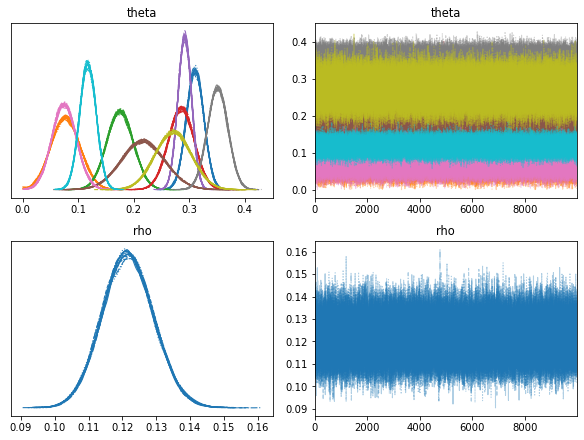

In [140]:
# Evaluate fit
arviz.plot_trace(fit, figsize=(8, 6));

In [142]:
print(fit)
print()
print(true_transmission_rate)
print(base_rate)

Inference for Stan model: tt_mod_d348a5d8586623ddc3995113fed4ea2b.
16 chains, each with iter=20000; warmup=10000; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=160000.

            mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[1]    0.31  3.3e-5   0.02   0.28    0.3   0.31   0.32   0.34 226406    1.0
theta[2]    0.08  5.9e-5   0.03   0.03   0.06   0.08   0.09   0.13 187112    1.0
theta[3]    0.18  5.0e-5   0.02   0.13   0.16   0.18   0.19   0.22 223549    1.0
theta[4]    0.29  4.7e-5   0.02   0.24   0.27   0.29    0.3   0.33 237882    1.0
theta[5]    0.29  2.7e-5   0.01   0.27   0.28   0.29    0.3   0.32 209153    1.0
theta[6]    0.22  8.0e-5   0.04   0.14   0.19   0.22   0.24   0.29 232726    1.0
theta[7]    0.08  4.9e-5   0.02   0.03   0.06   0.07   0.09   0.12 196746    1.0
theta[8]    0.35  3.8e-5   0.02   0.32   0.34   0.35   0.36   0.39 235315    1.0
theta[9]    0.27  6.5e-5   0.03   0.21   0.25   0.27   0.29   0.33 244797    1.0